In [31]:
import os
import time
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

from keras import datasets, layers, models
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, AveragePooling2D, Flatten, MaxPooling2D, Dense, GlobalAveragePooling2D

# Transfer learning models
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2

# metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve


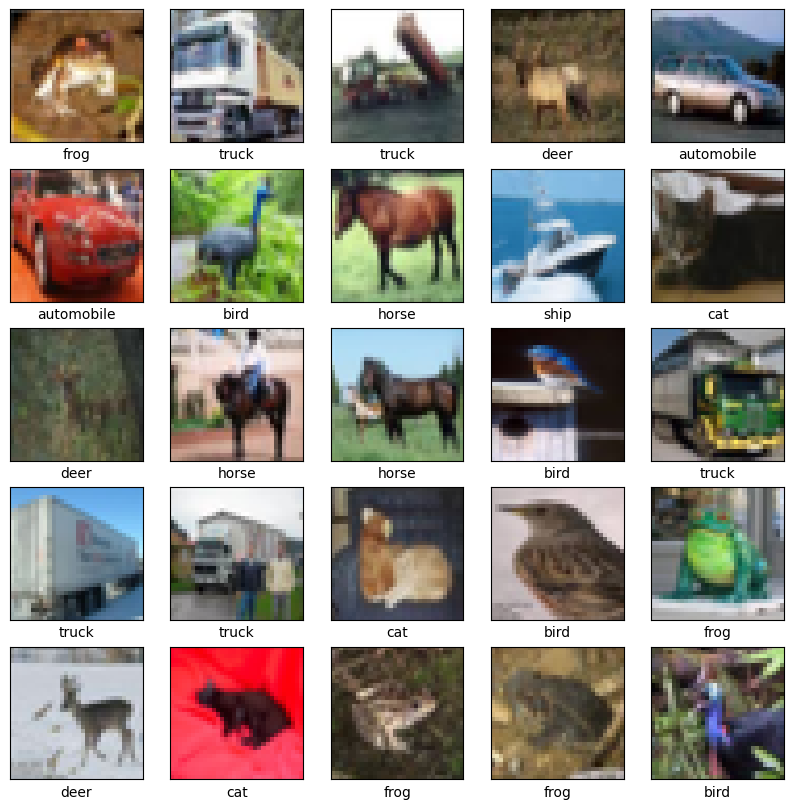

In [17]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)             

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 11s 6ms/step - loss: 1.5230 - accuracy: 0.4453 - val_loss: 1.2397 - val_accuracy: 0.5602
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1654 - accuracy: 0.5882 - val_loss: 1.2039 - val_accuracy: 0.5749
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0221 - accuracy: 0.6379 - val_loss: 1.0002 - val_accuracy: 0.6544
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9233 - accuracy: 0.6740 - val_loss: 0.9287 - val_accuracy: 0.6715
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8533 - accuracy: 0.6988 - val_loss: 0.9089 - val_accuracy: 0.6837
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7967 - accuracy: 0.7181 - val_loss: 0.8973 - val_accuracy: 0.6899
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7490 - accuracy: 0.7383 - val_loss: 0.8707 - val_accura

313/313 - 1s - loss: 0.8835 - accuracy: 0.7017 - 1s/epoch - 4ms/step


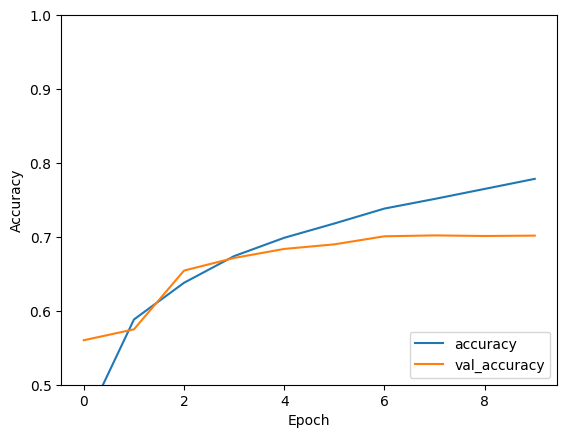

In [23]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [24]:
print(test_acc)

0.70169997215271


In [25]:
print(test_loss)

0.8834643363952637


In [26]:
y_pred = np.argmax(model.predict(test_images), axis=-1)
# classification report
print(classification_report(test_labels, y_pred, target_names = class_names))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.72      0.72      0.72      1000
  automobile       0.84      0.78      0.81      1000
        bird       0.56      0.65      0.60      1000
         cat       0.64      0.34      0.44      1000
        deer       0.61      0.71      0.66      1000
         dog       0.59      0.65      0.62      1000
        frog       0.73      0.82      0.77      1000
       horse       0.75      0.73      0.74      1000
        ship       0.81      0.81      0.81      1000
       truck       0.78      0.81      0.80      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



In [27]:
# save the model

model.save('/content/baseline_model.h5')


## ResNet50 model


In [29]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Freeze the base model layers
for layer in resnet_model.layers[:10]:
    layer.trainable = False
# Add a new classification head
fine_tune = resnet_model.output
fine_tune = GlobalAveragePooling2D()(fine_tune)
fine_tune = Dense(128, activation='relu')(fine_tune)
fine_tune = Dropout(0.2)(fine_tune)
fine_tune = Dense(10)(fine_tune)

# Define the new model
resnet50_model = Model(inputs=resnet_model.input, outputs=fine_tune)

resnet50_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = resnet50_model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 106s 47ms/step - loss: 1.4292 - accuracy: 0.5098 - val_loss: 2.3036 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 71s 45ms/step - loss: 1.3398 - accuracy: 0.5359 - val_loss: 2.3055 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 68s 44ms/step - loss: 1.2569 - accuracy: 0.5692 - val_loss: 2.4715 - val_accuracy: 0.1001
Epoch 4/10
1563/1563 [==============================] - 73s 47ms/step - loss: 1.0936 - accuracy: 0.6250 - val_loss: 6.9169 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 73s 47ms/step - loss: 0.9972 - accuracy: 0.6619 - val_loss: 2.3751 - val_accuracy: 0.0996
Epoch 6/10
1563/1563 [==============================] - 72s 46ms/step - loss: 1.0279 - accuracy: 0.6479 - val_loss: 30.9735 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 70s 45ms/step - loss: 1.0127 - accuracy: 0.6521 - val_loss: 2.3205

Despite ResNet50 showing increasing training accuracy as number of epochs increases, the validation accuracy is very low and therefore, we cannot continue with this model.

We will test other models like VGG16,  and DenseNet121.
For InceptionResNet_v2, we have limitation -> Input size must be at least 75x75 pixels and our image sizes are 32 x 32.

# VGG16

In [33]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Freeze the some few lower layers
for layer in vgg16.layers[:10]:
    layer.trainable = False
# Add a new classification head
fine_tune_vgg = vgg16.output
fine_tune_vgg = GlobalAveragePooling2D()(fine_tune_vgg)
fine_tune_vgg = Dense(128, activation='relu')(fine_tune_vgg)
fine_tune_vgg = Dropout(0.2)(fine_tune_vgg)
fine_tune_vgg = Dense(10)(fine_tune_vgg)

# Define the new model
vgg16_model = Model(inputs=vgg16.input, outputs=fine_tune_vgg)

vgg16_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_3 = vgg16_model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/10
1563/1563 [==============================] - 44s 26ms/step - loss: 2.3086 - accuracy: 0.0968 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 40s 25ms/step - loss: 2.3028 - accuracy: 0.0993 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 37s 24ms/step - loss: 2.3028 - accuracy: 0.1001 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 38s 24ms/step - loss: 2.3028 - accuracy: 0.0982 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 38s 24ms/step - loss: 2.3028 - accuracy: 0.0994 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 38s 24ms/step - loss: 2.3028 - accuracy: 0.0987 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 40s

# DenseNet121

In [36]:
from keras.applications.densenet import DenseNet121
base_densenet = DenseNet121(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (32,32,3)))
# Unfreeze more layers and test with densenet
for layer in base_densenet.layers[:35]:
    layer.trainable = False
for layer in base_densenet.layers[35:]:
    layer.trainable = True

densenet = base_densenet.output
densenet = GlobalAveragePooling2D()(densenet)
densenet = Flatten(name = 'flatten')(densenet)
densenet = Dense(256, activation = 'relu')(densenet)
densenet = Dropout(0.3)(densenet)
densenet = Dense(128, activation = 'relu')(densenet)
densenet = Dropout(0.2)(densenet)
densenet = Dense(10,activation = 'softmax')(densenet)
densenet121_model = Model(inputs=base_densenet.input, outputs = densenet)

densenet121_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_4 = densenet121_model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 204s 83ms/step - loss: 1.2178 - accuracy: 0.5968 - val_loss: 1.0623 - val_accuracy: 0.6565
Epoch 2/10
1563/1563 [==============================] - 123s 79ms/step - loss: 0.8733 - accuracy: 0.7157 - val_loss: 0.9161 - val_accuracy: 0.6972
Epoch 3/10
1563/1563 [==============================] - 124s 79ms/step - loss: 0.8426 - accuracy: 0.7234 - val_loss: 0.6671 - val_accuracy: 0.7813
Epoch 4/10
1563/1563 [==============================] - 151s 97ms/step - loss: 0.8155 - accuracy: 0.7303 - val_loss: 0.7583 - val_accuracy: 0.7369
Epoch 5/10
1563/1563 [==============================] - 124s 79ms/step - loss: 0.8425 - accuracy: 0.7170 - val_loss: 2.3374 - val_accuracy: 0.7405
Epoch 6/10
1563/1563 [==============================] - 157s 101ms/step - loss: 0.8467 - accuracy: 0.7160 - val_loss: 1.5345 - val_accuracy: 0.5186
Epoch 7/10
1563/1563 [==============================] - 148s 95ms/step - loss: 0.8434 - accuracy: 0.7158 - val_loss: 

313/313 - 4s - loss: 0.9643 - accuracy: 0.6732 - 4s/epoch - 12ms/step


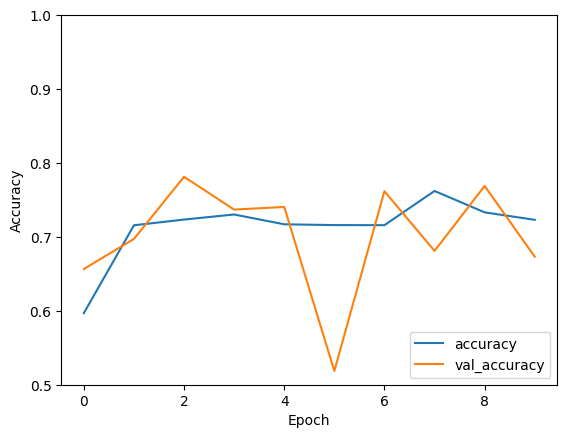

In [37]:
plt.plot(history_4.history['accuracy'], label='accuracy')
plt.plot(history_4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

densenet_test_loss, densenet_test_acc = densenet121_model.evaluate(test_images,  test_labels, verbose=2)

From pretrained models ResNet50, VGG16, InceptionResNet and DenseNet121, freezing few layers results to very low validation accuracy of the model. However, as you adjust freezable layers, better performance is obtained.

Let's redo ResNet50 again and see!



# ResNet50 Trial 2

In [38]:
# ResNet50 - Freezing 35 layers

resnet50_test_2 = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (32,32,3)))
# Unfreeze more layers and test with resnet50
for layer in resnet50_test_2.layers[:35]:
    layer.trainable = False
for layer in resnet50_test_2.layers[35:]:
    layer.trainable = True

resnet_test_2 = resnet50_test_2.output
resnet_test_2 = GlobalAveragePooling2D()(resnet_test_2)
resnet_test_2 = Flatten(name = 'flatten')(resnet_test_2)
resnet_test_2 = Dense(256, activation = 'relu')(resnet_test_2)
resnet_test_2 = Dropout(0.3)(resnet_test_2)
resnet_test_2 = Dense(128, activation = 'relu')(resnet_test_2)
resnet_test_2 = Dropout(0.2)(resnet_test_2)
resnet_test_2 = Dense(10,activation = 'softmax')(resnet_test_2)
resnet_test_2_model = Model(inputs=resnet50_test_2.input, outputs = resnet_test_2)

resnet_test_2_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_5 = resnet_test_2_model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 116s 47ms/step - loss: 1.9607 - accuracy: 0.2715 - val_loss: 4.7617 - val_accuracy: 0.1764
Epoch 2/10
1563/1563 [==============================] - 70s 45ms/step - loss: 1.7249 - accuracy: 0.3572 - val_loss: 2.4365 - val_accuracy: 0.1156
Epoch 3/10
1563/1563 [==============================] - 67s 43ms/step - loss: 1.6290 - accuracy: 0.4061 - val_loss: 2.3600 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 66s 42ms/step - loss: 1.5523 - accuracy: 0.4436 - val_loss: 2.3586 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 73s 47ms/step - loss: 1.5258 - accuracy: 0.4550 - val_loss: 2.3561 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 72s 46ms/step - loss: 1.4714 - accuracy: 0.4779 - val_loss: 2.5635 - val_accuracy: 0.1003
Epoch 7/10
1563/1563 [==============================] - 83s 53ms/step - loss: 1.4924 - accuracy: 0.4704 - val_loss: 3.1622 

From all these experiments, the baseline model appears to be performing better at 10 epochs. Therefore, we will use it to test our deployment.

For Transfer Learning based models, DenseNet121 appears to perform better that Vgg16 and ResNet50.

For better performances of TL based models, more experiments should be carried out by determining number of layers to freeze to get optimal results.

It is after this that data augmentation techniques like adjuusting images brightness and contrast will be applied to optimize performance of models.

**Final results**

In [39]:
resnet_test_loss, resnet_test_acc = resnet_test_2_model.evaluate(test_images,  test_labels, verbose=2)
vgg_test_loss, vgg_test_acc = vgg16_model.evaluate(test_images,  test_labels, verbose=2)
print(f"Test accuracy of Baseline model: {test_acc}")
print(f"Test accuracy of vgg16 model: {vgg_test_acc}")
print(f"Test accuracy of ResNet50 model: {resnet_test_acc}")
print(f"Test accuracy of DenseNet121 model: {densenet_test_acc}")

313/313 - 4s - loss: 10.6537 - accuracy: 0.0868 - 4s/epoch - 12ms/step
313/313 - 2s - loss: 2.3026 - accuracy: 0.1000 - 2s/epoch - 8ms/step
Test accuracy of Baseline model: 0.70169997215271
Test accuracy of vgg16 model: 0.10000000149011612
Test accuracy of ResNet50 model: 0.0868000015616417
Test accuracy of DenseNet121 model: 0.6732000112533569
